# **Importing the necessary libraries**

In [1]:
import json
import os
import pandas as pd
import numpy as np
from collections import defaultdict
from datetime import datetime
import argparse
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

# **Loading The Data**

In [2]:
with open("/content/user-wallet-transactions.json") as f:
    data = json.load(f)

records = []
for txn in data:
    records.append(txn)

df = pd.DataFrame(records)
print(df.head(2))

                                    _id  \
0  {'$oid': '681d38fed63812d4655f571a'}   
1  {'$oid': '681aa70dd6df53021cc6f3c0'}   

                                   userWallet  network protocol  \
0  0x00000000001accfa9cef68cf5371a23025b6d4b6  polygon  aave_v2   
1  0x000000000051d07a4fb3bd10121a343d85818da6  polygon  aave_v2   

                                              txHash  \
0  0x695c69acf608fbf5d38e48ca5535e118cc213a89e3d6...   
1  0xe6fc162c86b2928b0ba9b82bda672763665152b9de9d...   

                                               logId   timestamp  blockNumber  \
0  0x695c69acf608fbf5d38e48ca5535e118cc213a89e3d6...  1629178166   1629178166   
1  0xe6fc162c86b2928b0ba9b82bda672763665152b9de9d...  1621525013   1621525013   

    action                                         actionData  __v  \
0  deposit  {'type': 'Deposit', 'amount': '2000000000', 'a...    0   
1  deposit  {'type': 'Deposit', 'amount': '145000000000000...    0   

                               createdAt  \


In [3]:
print(df['userWallet'].value_counts())

userWallet
0x05c9db563db8e38cc2899297da41ce430b61a484    14265
0x0298b2ecdef68bc139b098461217a5b3161b69c8     1227
0x04d9f6ecd792e48a09fa5dc2138baed8e628a7e5     1089
0x047a96ef72d7ee6a3f193bdb92e998fb300265df      820
0x005f16f017aa933bb41965b52848ceb8ee48b171      767
                                              ...  
0x042ca8981305042407c7d27bafc373c005b8790e        1
0x042b12e77388ca4f9c773b49efe98115b9c5839e        1
0x0429e9a1931ae77fe39b6c17d7660382c85d28f2        1
0x0428be07db700e3b25addff63567584a3b15fdcc        1
0x060aa29adb1e32a4d5471461ea5e9815028a82c5        1
Name: count, Length: 3497, dtype: int64


In [4]:
print(df.groupby('action').size())

action
borrow              17086
deposit             37808
liquidationcall       248
redeemunderlying    32305
repay               12553
dtype: int64


# **Getting Scores using Hueristic formula**

formula= 300 * repay_to_borrow +
        300 * (1 - liquidation_ratio) +
        200 * min(1, np.log1p(deposit) / 10) +
        200 * (active_days / time_span)
### Explanation of the Formula
* 300 * repay_to_borrow
        1. Measures how well a wallet repays what it borrows.

        2. repay_to_borrow = repay / borrow

        3. A high ratio (close to 1) means they repay all debts → good behavior.

        4. If they borrow and never repay → ratio is 0 → credit risk.
* 200 * min(1, np.log1p(deposit) / 10)
        1. Measures the total deposited capital (log-scaled)

        2. np.log1p(deposit) scales deposit amount logarithmically

        3. Prevents whales from unfairly inflating scores just by dumping money

        4. Doesn't affect our score much so weights = 200

* 200 * (active_days / time_span)
        1. Measures consistency

        2. If a wallet interacts frequently and consistently over time, it’s less likely to be a bot or one-time exploit.

        3. active_days / time_span is engagement frequency
        
* 300 * (1 - liquidation_ratio)
        1. Measures how often the wallet got liquidated.

        2. liquidation_ratio = liquidationcalls / total_txns

        3. A wallet that never gets liquidated → good risk management.

        4. Liquidations mean they over-leveraged or mismanaged assets

In [5]:
def parse_timestamp(ts):
    if isinstance(ts, dict) and '$date' in ts:
        return datetime.fromisoformat(ts['$date'].replace('Z', '+00:00'))
    elif isinstance(ts, str):
        try:
            return datetime.fromisoformat(ts.replace('Z', '+00:00'))
        except ValueError:
            pass
    elif isinstance(ts, (int, float)):
        return datetime.utcfromtimestamp(ts)
    return None


def score_wallet(wallet_data):
    txns = wallet_data["transactions"]
    actions = [tx["action"] for tx in txns]
    timestamps = [parse_timestamp(tx["timestamp"]) for tx in txns if parse_timestamp(tx["timestamp"]) is not None]
    amounts = defaultdict(float)

    for tx in txns:
        action = tx["action"].lower()
        try:
            amount = float(tx.get("actionData", {}).get("amount", 0))
        except (ValueError, TypeError):
            amount = 0.0  # Assign 0 if conversion fails
        amounts[action] += amount

    borrow = amounts['borrow']
    repay = amounts['repay']
    deposit = amounts['deposit']
    redeem = amounts['redeemunderlying']
    liquidations = actions.count("liquidationcall")

    # Safe ratios
    repay_to_borrow = repay / borrow if borrow > 0 else 1
    liquidation_ratio = liquidations / len(txns) if txns else 0
    redeem_to_deposit = redeem / deposit if deposit > 0 else 1

    active_days = len(set(ts.date() for ts in timestamps))
    time_span = (max(timestamps) - min(timestamps)).days + 1 if timestamps else 1 # Avoid division by zero

    # Heuristic scoring formula
    score = (
        300 * repay_to_borrow +
        300 * (1 - liquidation_ratio) +
        200 * min(1, np.log1p(deposit) / 10) +
        200 * (active_days / time_span)
    )
    return min(1000, max(0, int(score)))

def calculate_wallet_scores(df):
    results = {}
    for wallet, group_df in df.groupby('userWallet'):
        wallet_data = {"transactions": group_df.to_dict('records')}
        results[wallet] = score_wallet(wallet_data)
    metadata = pd.Series(data)
    return results

In [6]:
wallet_scores = calculate_wallet_scores(df)
Df2 = pd.Series(wallet_scores, name='Score').to_frame()
Df2.to_json("scores.json")
Df2['userWallet']=Df2.index
Df2.reset_index(drop=True,inplace=True)
print("**************")
print(Df2)

**************
      Score                                  userWallet
0      1000  0x00000000001accfa9cef68cf5371a23025b6d4b6
1      1000  0x000000000051d07a4fb3bd10121a343d85818da6
2       850  0x000000000096026fb41fc39f9875d164bd82e2dc
3       612  0x0000000000e189dd664b9ab08a33c4839953852c
4       656  0x0000000002032370b971dabd36d72f3e5a7bf1ee
...     ...                                         ...
3492    891  0x06185db89f5c8ef5e5a0abc95c5cb69b54c33f30
3493    700  0x06189341e523a52ae10c4bd4a7774371fac1b249
3494   1000  0x0618c450370822c5cb25ec143a3008230d8e2c12
3495    618  0x0618e615c8c9b5efc8c8eadc68be7182bdc455e2
3496    728  0x06192f889f17bf2aff238d08d8c26cbcfcc7b45a

[3497 rows x 2 columns]


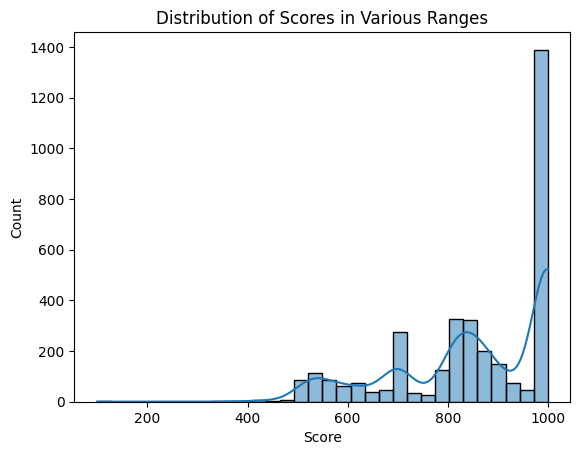

In [7]:
sns.histplot(Df2,x='Score',kde=True)
plt.title("Distribution of Scores in Various Ranges")
plt.savefig("Scores_by_snsplot.jpg")
plt.show()

In [8]:
merged_df = pd.merge(df, Df2, on='userWallet', how='inner')
print(merged_df.head(2))

                                    _id  \
0  {'$oid': '681d38fed63812d4655f571a'}   
1  {'$oid': '681aa70dd6df53021cc6f3c0'}   

                                   userWallet  network protocol  \
0  0x00000000001accfa9cef68cf5371a23025b6d4b6  polygon  aave_v2   
1  0x000000000051d07a4fb3bd10121a343d85818da6  polygon  aave_v2   

                                              txHash  \
0  0x695c69acf608fbf5d38e48ca5535e118cc213a89e3d6...   
1  0xe6fc162c86b2928b0ba9b82bda672763665152b9de9d...   

                                               logId   timestamp  blockNumber  \
0  0x695c69acf608fbf5d38e48ca5535e118cc213a89e3d6...  1629178166   1629178166   
1  0xe6fc162c86b2928b0ba9b82bda672763665152b9de9d...  1621525013   1621525013   

    action                                         actionData  __v  \
0  deposit  {'type': 'Deposit', 'amount': '2000000000', 'a...    0   
1  deposit  {'type': 'Deposit', 'amount': '145000000000000...    0   

                               createdAt  \


# **Summarizing Behavior of wallets using Heuristic Score**
- Most of the wallets get a 1000 score .

In [9]:
def bin_scores(df):
    df["Score"] = df["Score"].clip(1, 1000)
    bins = np.arange(0, 1101, 100)
    labels = [f"{bins[i]}-{bins[i+1]-1}" for i in range(len(bins)-1)]
    df["score_range"] = pd.cut(df["Score"], bins=bins, labels=labels, include_lowest=True, right=False)
    return df

def plot_distribution(df):
    plt.figure(figsize=(8, 5))
    sns.histplot(df["Score"], bins=30, kde=True, color="skyblue", edgecolor="black")
    plt.title("Distribution of Wallet Credit Scores")
    plt.xlabel("Score")
    plt.ylabel("Wallet Count")
    plt.tight_layout()
    plt.savefig("score_dist_from_df.png")
    plt.close()

def summarize_behavior(transactions):
    summary = defaultdict(int)
    count = len(transactions)

    for tx in transactions:
        action = tx.get("action", "").lower()
        summary[action] += 1

    avg_behavior = {k: v / count for k, v in summary.items()} if count > 0 else {}
    return avg_behavior

def write_analysis(df):
    os.makedirs("analysis_output", exist_ok=True)
    score_bins = df["score_range"].value_counts().sort_index()

    low_df = df[df["Score"] < 400]
    high_df = df[df["Score"] >= 800]
    low_behavior = summarize_behavior(low_df.to_dict('records'))
    high_behavior = summarize_behavior(high_df.to_dict('records'))


    with open("analysis_output/analysis_from_df.md", "w") as f:
        f.write("# Credit Score Analysis from Merged DataFrame\n\n")
        f.write("### Score Distribution\n\n")
        f.write("![Score Histogram](../score_dist_from_df.png)\n\n")

        f.write("#### Bin Counts:\n")
        for bin_label, count in score_bins.items():
            f.write(f"- **{bin_label}**: {count} wallets\n")

        f.write("\n---\n\n")
        f.write("### Behavior of Low Score Wallets (Score < 400)\n")
        if not low_behavior:
            f.write("No low-score wallets found.\n")
        else:
            for action, avg in low_behavior.items():
                f.write(f"- {action}: {avg:.2f} times per wallet\n")

        f.write("\n---\n\n")
        f.write("### Behavior of High Score Wallets (Score >= 800)\n")
        if not high_behavior:
            f.write("No high-score wallets found.\n")
        else:
            for action, avg in high_behavior.items():
                f.write(f"- {action}: {avg:.2f} times per wallet\n")

        f.write("\n---\n\n")
        f.write("_Generated from `merged_data.json` or DataFrame._\n")

    print("Analysis complete. See:")
    print(" - analysis_output/analysis_from_df.md")
    print(" - score_dist_from_df.png")

def main():
    df = merged_df
    df = bin_scores(df)
    plot_distribution(df)
    write_analysis(df)

if __name__ == "__main__":
    main()

Analysis complete. See:
 - analysis_output/analysis_from_df.md
 - score_dist_from_df.png


# **Extracting Features and training Random Forest Regressor**

In [10]:

def extract_features(transactions):
    actions = [tx["action"].lower() for tx in transactions]
    n_txns = len(transactions)

    borrow = sum(float(tx.get("actionData", {}).get("amount", 0)) for tx in transactions if tx["action"].lower() == "borrow")
    repay = sum(float(tx.get("actionData", {}).get("amount", 0)) for tx in transactions if tx["action"].lower() == "repay")
    deposit = sum(float(tx.get("actionData", {}).get("amount", 0)) for tx in transactions if tx["action"].lower() == "deposit")
    redeem = sum(float(tx.get("actionData", {}).get("amount", 0)) for tx in transactions if tx["action"].lower() == "redeemunderlying")
    liquidation_count = actions.count("liquidationcall")
    repay_ratio = repay / borrow if borrow else 1
    liquidation_ratio = liquidation_count / n_txns if n_txns else 0

    return {
        "n_txns": n_txns,
        "borrow": borrow,
        "repay": repay,
        "deposit": deposit,
        "redeem": redeem,
        "repay_ratio": repay_ratio,
        "liquidation_ratio": liquidation_ratio
    }

wallets = []
features = []


for wallet, wallet_df in merged_df.groupby('userWallet'):
    wallets.append(wallet)
    transactions = wallet_df.to_dict('records')
    features.append(extract_features(transactions))

df_features = pd.DataFrame(features, index=wallets)

# --- Pseudo-label: good if repay_ratio ≥ 0.9, liquidation_ratio ≤ 0.1
df_features["label"] = ((df_features["repay_ratio"] >= 0.9) & (df_features["liquidation_ratio"] <= 0.1)).astype(int)


model = RandomForestRegressor()
X = df_features.drop("label", axis=1)
y=Df2['Score']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model.fit(X_train, y_train)
scores = np.clip(model.predict(X), 0, 1000)
df_features['ml_score']=scores
credit_scores_ml = {wallet: int(score) for wallet, score in zip(df_features.index, df_features["ml_score"])}
with open("ml_credit_scores.json", "w") as f:
    json.dump(credit_scores_ml, f, indent=2)

print("ML-based scores saved to ml_credit_scores.json")

ML-based scores saved to ml_credit_scores.json


      Score                                  userWallet
0      1000  0x00000000001accfa9cef68cf5371a23025b6d4b6
1      1000  0x000000000051d07a4fb3bd10121a343d85818da6
2       859  0x000000000096026fb41fc39f9875d164bd82e2dc
3       622  0x0000000000e189dd664b9ab08a33c4839953852c
4       659  0x0000000002032370b971dabd36d72f3e5a7bf1ee
...     ...                                         ...
3492    891  0x06185db89f5c8ef5e5a0abc95c5cb69b54c33f30
3493    643  0x06189341e523a52ae10c4bd4a7774371fac1b249
3494    969  0x0618c450370822c5cb25ec143a3008230d8e2c12
3495    598  0x0618e615c8c9b5efc8c8eadc68be7182bdc455e2
3496    716  0x06192f889f17bf2aff238d08d8c26cbcfcc7b45a

[3497 rows x 2 columns]
**************


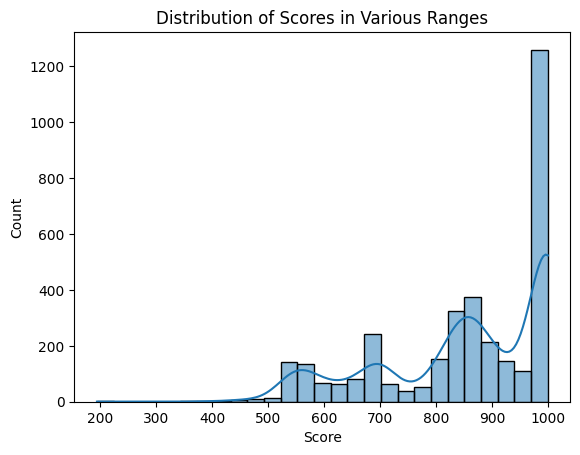

In [11]:
Df_ml=pd.Series(credit_scores_ml, name='Score').to_frame()
Df_ml['userWallet']=Df_ml.index
Df_ml.reset_index(drop=True,inplace=True)
print(Df_ml)
print("**************")
sns.histplot(Df_ml,x='Score',kde=True)
plt.title("Distribution of Scores in Various Ranges")
plt.savefig("ML_Scores_by_snsplot.jpg")
plt.show()

# **Classifying user wallets as Whale, Bot etc.**

In [12]:
def classify_wallet(row):
    if row["deposit"] > 100000 and row["n_txns"] < 10:
        return "Whale"
    elif row["n_txns"] > 100 and row["deposit"] < 500:
        return "Bot"
    elif row["deposit"] > 0 and row["redeem"] > 0 and row["n_txns"] > 10:
        return "Farmer"
    else:
        return "Other"

df_features["behavior_type"] = df_features.apply(classify_wallet, axis=1)

score_mapping = {
    "Whale": 950,
    "Farmer": 800,
    "Other": 600,
    "Bot": 200
}

df_features["cluster_score"] = df_features["behavior_type"].map(score_mapping)

wallet_scores_cluster = {
    wallet: {
        "behavior": df_features.loc[wallet, "behavior_type"],
        "score": int(df_features.loc[wallet, "cluster_score"])
    }
    for wallet in df_features.index
}

with open("cluster_credit_scores.json", "w") as f:
    json.dump(wallet_scores_cluster, f, indent=2)

print("Cluster-based behavior scores saved to cluster_credit_scores.json")

Cluster-based behavior scores saved to cluster_credit_scores.json


In [13]:
print(df_features['behavior_type'].value_counts())

behavior_type
Whale     2179
Farmer     941
Other      374
Bot          3
Name: count, dtype: int64


**Classification of Behavior of User Wallet**

| Behavior Type | Reasoning                         | Score |
| ------------- | --------------------------------- | ----- |
| **Whales**    | Big money, `fewer actions — safe` | 950   |
| **Farmers**   |`Balanced usage` — lending/earning | 800   |
| **Bots**      | High-frequency, low value —`risky`| 200   |
| **Other**     | Mixed or unclear pattern          | 600   |


# **Summarizing Behavior using Scores obtained with ML model**

In [14]:
merged_df_with_ml = pd.merge(df,Df_ml, on='userWallet', how='inner')
print(merged_df_with_ml.head(2))

                                    _id  \
0  {'$oid': '681d38fed63812d4655f571a'}   
1  {'$oid': '681aa70dd6df53021cc6f3c0'}   

                                   userWallet  network protocol  \
0  0x00000000001accfa9cef68cf5371a23025b6d4b6  polygon  aave_v2   
1  0x000000000051d07a4fb3bd10121a343d85818da6  polygon  aave_v2   

                                              txHash  \
0  0x695c69acf608fbf5d38e48ca5535e118cc213a89e3d6...   
1  0xe6fc162c86b2928b0ba9b82bda672763665152b9de9d...   

                                               logId   timestamp  blockNumber  \
0  0x695c69acf608fbf5d38e48ca5535e118cc213a89e3d6...  1629178166   1629178166   
1  0xe6fc162c86b2928b0ba9b82bda672763665152b9de9d...  1621525013   1621525013   

    action                                         actionData  __v  \
0  deposit  {'type': 'Deposit', 'amount': '2000000000', 'a...    0   
1  deposit  {'type': 'Deposit', 'amount': '145000000000000...    0   

                               createdAt  \


In [15]:
def bin_scores(df):
    df["Score"] = df['Score'].clip(1, 1000)
    bins = np.arange(0, 1101, 100)
    labels = [f"{bins[i]}-{bins[i+1]-1}" for i in range(len(bins)-1)]
    df["score_range"] = pd.cut(df["Score"], bins=bins, labels=labels, include_lowest=True, right=False)
    return df

def plot_distribution(df):
    plt.figure(figsize=(8, 5))
    sns.histplot(df["Score"], bins=30, kde=True, color="skyblue", edgecolor="black")
    plt.title("Distribution of Wallet Credit Scores")
    plt.xlabel("Score")
    plt.ylabel("Wallet Count")
    plt.tight_layout()
    plt.savefig("score_dist_from_df_ml.png")
    plt.close()

def summarize_behavior(transactions):
    summary = defaultdict(float)
    count = len(transactions)

    for tx in transactions:
        action = tx.get("action", "").lower()
        try:
            amount = float(tx.get("actionData", {}).get("amount", 0))
        except (ValueError, TypeError):
            amount = 0.0

        if action == "borrow":
            summary['total_borrow'] += amount
        elif action == "repay":
            summary['total_repay'] += amount
        elif action == "deposit":
            summary['total_deposit'] += amount
        elif action == "redeemunderlying":
            summary['total_redeem'] += amount

        summary[f'{action}_count'] += 1

    avg_behavior = {}
    avg_behavior['avg_borrow'] = summary['total_borrow'] / count
    avg_behavior['avg_repay'] = summary['total_repay'] / count
    avg_behavior['avg_deposit'] = summary['total_deposit'] / count
    avg_behavior['avg_redeem'] = summary['total_redeem'] / count

    avg_behavior['repay_to_borrow_ratio'] = summary['total_repay'] / summary['total_borrow'] if summary['total_borrow'] > 0 else 1
    avg_behavior['liquidation_ratio'] = summary['liquidationcall_count'] / count if count > 0 else 0


    for action in ['borrow', 'repay', 'deposit', 'redeemunderlying', 'liquidationcall']:
        avg_behavior[f'%_{action}'] = summary[f'{action}_count'] / count * 100 if count > 0 else 0


    return avg_behavior


def write_analysis(df):
    os.makedirs("analysis_output", exist_ok=True)
    score_bins = df["score_range"].value_counts().sort_index()

    low_df = df[df["Score"] < 400]
    high_df = df[df["Score"] >= 800]

    low_behavior = summarize_behavior(low_df.to_dict('records'))
    high_behavior = summarize_behavior(high_df.to_dict('records'))


    with open("analysis_output/analysis_from_df_ml.md", "w") as f:
        f.write("# Credit Score Analysis from Merged DataFrame\n\n")
        f.write("### Score Distribution\n\n")
        f.write("![Score Histogram](../score_dist_from_df_ml.png)\n\n")

        f.write("#### Bin Counts:\n")
        for bin_label, count in score_bins.items():
            f.write(f"- **{bin_label}**: {count} wallets\n")

        f.write("\n---\n\n")
        f.write("### Behavior of Low Score Wallets (Score < 400)\n")
        if not low_behavior:
            f.write("No low-score wallets found.\n")
        else:
            for action, avg in low_behavior.items():
                f.write(f"- {action}: {avg:.2f}\n") # Removed 'times per wallet' as it's not always an average count

        f.write("\n---\n\n")
        f.write("### Behavior of High Score Wallets (Score >= 800)\n")
        if not high_behavior:
            f.write("No high-score wallets found.\n")
        else:
            for action, avg in high_behavior.items():
                f.write(f"- {action}: {avg:.2f}\n") # Removed 'times per wallet'

        f.write("\n---\n\n")
        f.write("_Generated from `df_features` or DataFrame._\n")

    print("Analysis complete. See:")
    print(" - analysis_output/analysis_from_df_ml.md")
    print(" - score_dist_from_df_ml.png")


def main():
    df = merged_df_with_ml
    df = bin_scores(df)
    plot_distribution(df)
    write_analysis(df)


if __name__ == "__main__":
    main()

Analysis complete. See:
 - analysis_output/analysis_from_df_ml.md
 - score_dist_from_df_ml.png
